# Crypto Predictions based on Indicators with XGBoost

This notebook is using tradeview.com data with various indicators to determine which indicators are the strongest.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from pathlib import Path
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

/Users/rachelbates/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(250,250,250,0.8)'
)

fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [21]:
# Import the data into a Pandas Dataframe
btc_df = pd.read_csv(
    Path('csv_files/MATIC/MATICUSD_15_minute.csv'), 
    infer_datetime_format=True, 
    parse_dates=True
)


btc_df['time'] = pd.to_datetime(btc_df['time'])
btc_df.index = range(len(btc_df))
img_name = 'matic_15m_'

# Review the DataFrame
btc_df

,time,open,high,low,close,Plot,Up Trend,Down Trend,VWAP,Upper Band,...,Lower Bollinger Band,Histogram,MACD,Signal,CCI,Smoothing Line.1,ADX,+DI,-DI,CHOP
0,2022-03-26 03:15:00+00:00,1.575,1.580,1.575,1.578,1.5765,NaN,1.590493,1.578535,1.582199,...,NaN,0.000703,-0.003568,-0.004271,-19.886364,-58.459356,38.381925,14.972115,30.863065,55.073971
1,2022-03-26 03:30:00+00:00,1.578,1.580,1.577,1.579,1.5785,NaN,1.590493,1.578537,1.582171,...,NaN,0.000859,-0.003198,-0.004057,16.707087,-48.233499,38.116771,14.387191,29.657320,51.462447
2,2022-03-26 03:45:00+00:00,1.579,1.585,1.579,1.584,1.5815,NaN,1.590493,1.578690,1.582341,...,NaN,0.001267,-0.002473,-0.003740,122.605364,-16.423132,36.549443,19.738421,27.355478,57.515640
3,2022-03-26 04:00:00+00:00,1.584,1.586,1.583,1.583,1.5835,NaN,1.590493,1.578875,1.582592,...,NaN,0.001427,-0.001957,-0.003383,133.839983,31.977861,34.855653,20.283793,26.258087,54.695772
4,2022-03-26 04:15:00+00:00,1.583,1.583,1.578,1.582,1.5825,NaN,1.590493,1.578911,1.582606,...,NaN,0.001419,-0.001609,-0.003029,51.597052,60.972624,34.116995,18.921396,31.211093,53.083089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,2022-04-16 21:00:00+00:00,1.383,1.384,1.382,1.382,1.3825,1.372391,NaN,1.385796,1.394724,...,NaN,0.001475,-0.000691,-0.002166,178.443114,120.934285,23.366877,28.275974,20.273455,36.569152
2088,2022-04-16 21:15:00+00:00,1.382,1.385,1.382,1.384,1.3830,1.373052,NaN,1.385769,1.394642,...,NaN,0.001605,-0.000160,-0.001765,173.480663,140.570730,23.120612,28.573428,19.081051,36.569152
2089,2022-04-16 21:30:00+00:00,1.383,1.386,1.383,1.386,1.3845,1.374197,NaN,1.385765,1.394615,...,NaN,0.001745,0.000417,-0.001329,173.063973,161.547161,23.134615,28.856962,17.944443,34.271945
2090,2022-04-16 21:45:00+00:00,1.386,1.393,1.386,1.390,1.3880,1.378127,NaN,1.385813,1.394619,...,NaN,0.002009,0.001183,-0.000826,216.239687,184.210954,24.474913,38.119380,15.608179,25.467191


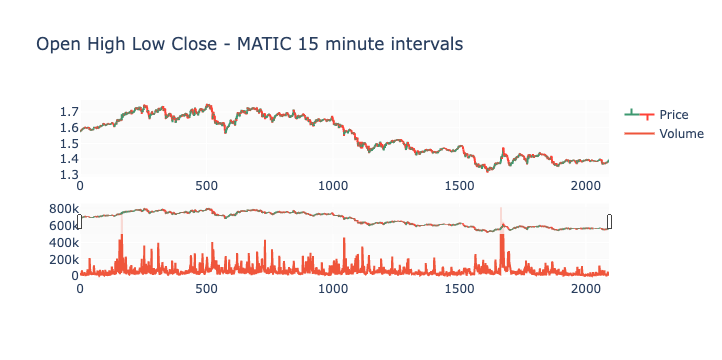

In [23]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=btc_df.index,
                      open=btc_df.open,
                      high=btc_df.high,
                      low=btc_df.low,
                      close=btc_df.close,
                      name='Price'), row=1, col=1)
fig.update_layout(
    title="Open High Low Close - MATIC 15 minute intervals"
    )

fig.add_trace(go.Scatter(x=btc_df.index, y=btc_df.Volume, name='Volume'), row=2, col=1)
fig.update(layout_xaxis_rangeslider_visible=True)
fig.show()
fig.write_image(f'images/{img_name}ohlc.png')

In [24]:
df_close = btc_df[['time', 'close']].copy()
df_close = df_close.set_index('time')
df_close.head()

,close
time,
2022-03-26 03:15:00+00:00,1.578
2022-03-26 03:30:00+00:00,1.579
2022-03-26 03:45:00+00:00,1.584
2022-03-26 04:00:00+00:00,1.583
2022-03-26 04:15:00+00:00,1.582


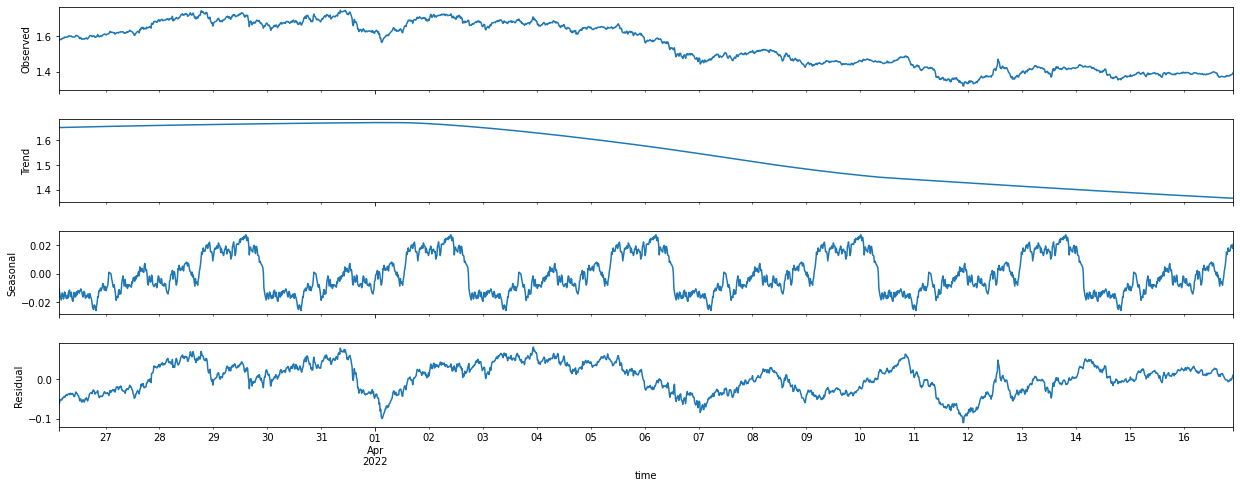

In [25]:
# Select the period to include here

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)
fig.savefig(f'images/{img_name}decomp.png')

### RSI to predict if the coin is overbought or over sold

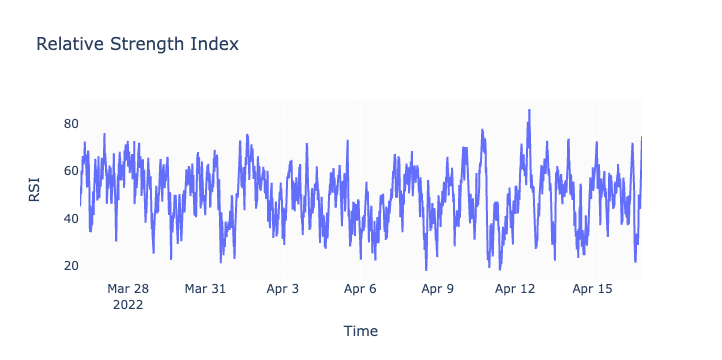

In [26]:
fig = go.Figure(go.Scatter(x=btc_df.time, y=btc_df.RSI, name='RSI'))
fig.update_layout(
    title='Relative Strength Index',
    xaxis_title='Time',
    yaxis_title='RSI'
    )
fig.show()
fig.write_image(f'images/{img_name}RSI.png')

### Indicators

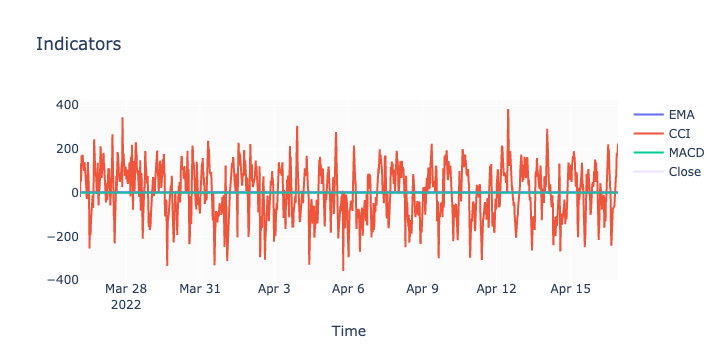

In [8]:
fig = go.Figure()
fig.update_layout(
    title='Indicators',
    xaxis_title='Time',
    )
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.EMA, name='EMA'))
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.CCI, name='CCI'))
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.MACD, name='MACD'))
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.close, name='Close', opacity=0.2))
fig.show()
fig.write_image(f'images/{img_name}RSI.png')

Split stock data frame into two subsets: training ($70\%$)and test ($30\%$) sets. Calculated split indices and create separate dataframes (train_df, test_df). Frames have been ploted in the chart below.

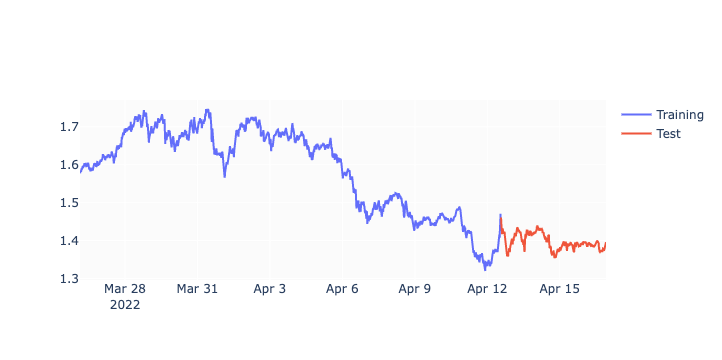

In [9]:
test_size  = 0.20
test_split_idx  = int(btc_df.shape[0] * (1-test_size))

train_df  = btc_df.loc[:test_split_idx - 1].copy()
test_df   = btc_df.loc[test_split_idx:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.time, y=train_df.close, name='Training'))
fig.add_trace(go.Scatter(x=test_df.time,  y=test_df.close,  name='Test'))
fig.show()
fig.write_image(f'images/{img_name}traintest.png')

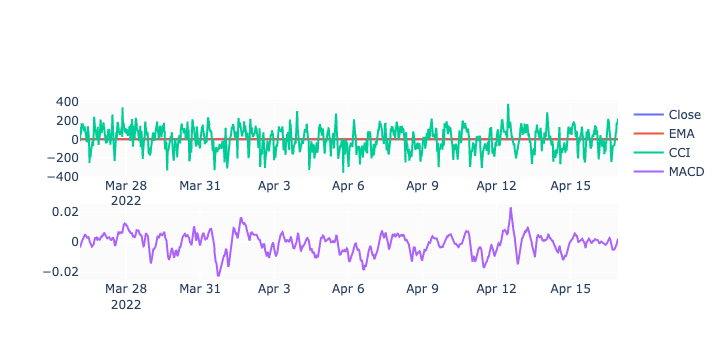

In [10]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['EMA'], name='EMA'), row=1, col=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['CCI'], name='CCI'), row=1, col=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df['MACD'], name='MACD'), row=2, col=1)
fig.show()
fig.write_image(f'images/{img_name}MACD.png')

### Drop Unnessary Columns

In [11]:
# This code needs to be optimized, they are manually changed depending on the desired idicators 
drop_cols = ['time', 'open', 'low', 'high', 'Plot','Up Trend', 
             'Down Trend', 'VWAP', 'Upper Band', 'Lower Band', 
             'Basis', 'Upper', 'Lower', 'Smoothing Line', 'Lead 1',
             'Lead 2', 'Lower Bollinger Band', 'Histogram', 
             'Smoothing Line.1', 'ADX', '+DI', '-DI', 'CHOP', 
             'Lagging Span', 'Volume', 'Volume MA', 'Upper Bollinger Band',
            'Signal', 'RSI-based MA', 'Tenkan', 'Kijun', 'RSI']

train_df = train_df.drop(drop_cols, axis=1).dropna()
test_df = test_df.drop(drop_cols, axis=1).dropna()

In [12]:
train_df.head()

,close,EMA,MACD,CCI
0,1.578,1.589650,-0.003568,-19.886364
1,1.579,1.589233,-0.003198,16.707087
2,1.584,1.589027,-0.002473,122.605364
3,1.583,1.588791,-0.001957,133.839983
4,1.582,1.588525,-0.001609,51.597052


### Split into features and labels

In [13]:
y_train = train_df['close'].copy()
X_train = train_df.drop(columns = ['close'])

y_test = test_df['close'].copy()
X_test = test_df.drop(columns = ['close'])


### Fine Tune XGRegressor

In [14]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42],  
}

model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0)

print(train_df.info())
print(test_df.info())
print(model)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1673 entries, 0 to 1672
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1673 non-null   float64
 1   EMA     1673 non-null   float64
 2   MACD    1673 non-null   float64
 3   CCI     1673 non-null   float64
dtypes: float64(4)
memory usage: 65.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 419 entries, 1673 to 2091
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   419 non-null    float64
 1   EMA     419 non-null    float64
 2   MACD    419 non-null    float64
 3   CCI     419 non-null    float64
dtypes: float64(4)
memory usage: 16.4 KB
None
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=Non

In [15]:
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')

Best params: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 100, 'random_state': 42}


In [16]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, verbose=False)

CPU times: user 1.69 s, sys: 402 ms, total: 2.09 s
Wall time: 554 ms


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.001, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

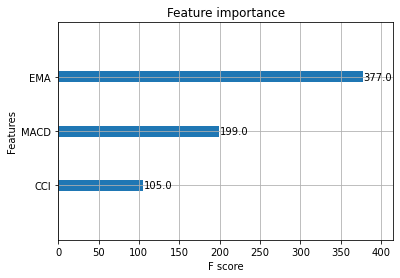

In [17]:
importance = plot_importance(model)
importance.figure.savefig(f'images/{img_name}importance.png')


### Calculate and Visualize Predictions

In [18]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [1.461 1.458 1.444 1.423 1.424]
y_pred = [1.414737 1.414737 1.414737 1.407163 1.407163]


In [19]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.0006991064051506367


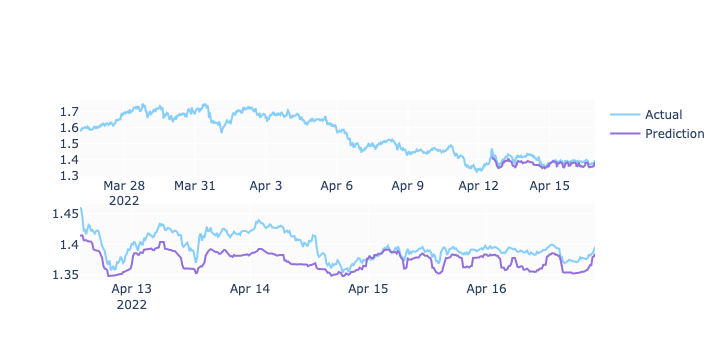

In [20]:
predicted_prices = btc_df.loc[test_split_idx:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=btc_df.time, y=btc_df.close,
                         name='Actual',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=y_test,
                         name='Actual',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()
fig.write_image(f'images/{img_name}predictions.png')